## Dichroic Mirror Optimization for Polarization Separation

We will optimize a thin-film stack to create a dichroic mirror that separates s and p polarizations at 600 nm. The goal is to maximize s-polarized reflection (Rs) while minimizing p-polarized reflection (Rp) at this wavelength.

In [1]:
from optiland.thin_film.optimization import ThinFilmOptimizer
import optiland.backend as be
from optiland.thin_film import ThinFilmStack, SpectralAnalyzer
from optiland.materials import Material, IdealMaterial

SiO2 = Material("SiO2", reference="Gao")
TiO2 = Material("TiO2", reference="Zhukovsky")
BK7 = Material("N-BK7", reference="SCHOTT")
air = IdealMaterial(n=1.0)

dichroic_stack = ThinFilmStack(
    incident_material=air, 
    substrate_material=BK7, 
    reference_wl_um=0.6,
    reference_AOI_deg=45.0,
)

for i in range(8):  # 8 pairs = 16 layers
    dichroic_stack.add_layer_qwot(material=TiO2, qwot_thickness=1.0, name=f"$TiO_2$")
    dichroic_stack.add_layer_qwot(material=SiO2, qwot_thickness=1.0, name=f"$SiO_2$")

# Calculate initial reflectances at 600 nm
Rs_initial = dichroic_stack.reflectance_nm_deg(600, 45, 's')
Rp_initial = dichroic_stack.reflectance_nm_deg(600, 45, 'p')
contrast_initial = be.abs(Rs_initial.item() - Rp_initial.item())

print(f"Polarization contrast (Rs-Rp) = {contrast_initial*100:.1f}%")

Polarization contrast (Rs-Rp) = 5.1%


In [2]:
optimizer = ThinFilmOptimizer(dichroic_stack)

# Add all thicknesses as optimization variables
# Constraints: 30-300 nm (reasonable for thin films)
for i in range(len(dichroic_stack.layers)):
    optimizer.add_thickness_variable(
        layer_index=i,
        min_nm=30,
        max_nm=300
    )

# Define optimization targets at 600 nm and 45°
optimizer.add_target(
    property="R",
    wavelength_nm=[600.0, 610.0],
    target_type="over", 
    value=[0.99, 0.99],
    weight=1.0,
    aoi_deg=45.0,
    polarization="s", 
    tolerance=1e-12
)

optimizer.add_target(
    property="R",
    wavelength_nm=[600.0, 610.0],
    target_type="below",
    value=[0.01, 0.01],
    weight=1.0,
    aoi_deg=45.0,
    polarization="p", 
    tolerance=1e-12
)

# Display optimization information
optimizer.info()

ThinFilm Optimizer Information
+--------------+---------+
| Property     |   Count |
+==============+=========+
| Stack layers |      16 |
+--------------+---------+
| Variables    |      16 |
+--------------+---------+
| Targets      |       2 |
+--------------+---------+

Variables:
+------+---------+------------------+------------+------------+
|   ID |   Layer |   Thickness (nm) |   Min (nm) |   Max (nm) |
+======+=========+==================+============+============+
|    0 |       0 |             88.2 |         30 |        300 |
+------+---------+------------------+------------+------------+
|    1 |       1 |            143.6 |         30 |        300 |
+------+---------+------------------+------------+------------+
|    2 |       2 |             88.2 |         30 |        300 |
+------+---------+------------------+------------+------------+
|    3 |       3 |            143.6 |         30 |        300 |
+------+---------+------------------+------------+------------+
|    4 |  

In [3]:
# Launch optimization
result = optimizer.optimize(
    method="L-BFGS-B",
    max_iterations=500,
    tolerance=1e-14,
    gtol =1e-14,
    verbose=False,
)
print(f"Merit: {result['initial_merit']:.15f} -> {result['final_merit']:.15f} in {result['iterations']} iterations")
print(f"   Improvement: {result['improvement']:.15f}")

# Calculate final performance
Rs_final = dichroic_stack.reflectance_nm_deg(600, 45, 's')
Rp_final = dichroic_stack.reflectance_nm_deg(600, 45, 'p')
contrast_final = Rs_final.item() - Rp_final.item()

print(f"\n📊 Performance comparison at 600 nm (AOI=45°):")
print(f"   Contrast: {contrast_initial:.3f} → {contrast_final:.3f}")

Merit: 0.639308392739956 -> 0.003694640332037 in 326 iterations
   Improvement: 0.635613752407919

📊 Performance comparison at 600 nm (AOI=45°):
   Contrast: 0.051 → 0.924


In [5]:
from optiland.thin_film.optimization import ThinFilmReport

report = ThinFilmReport(optimizer, result)
report.summary_table()

,Variable,Initial,Final,Change,Unit
0,Layer 0 thickness,88.2,62.9,-25.4 (-28.8%),nm
1,Layer 1 thickness,143.6,90.0,-53.6 (-37.3%),nm
2,Layer 2 thickness,88.2,49.3,-38.9 (-44.1%),nm
3,Layer 3 thickness,143.6,92.0,-51.6 (-35.9%),nm
4,Layer 4 thickness,88.2,52.6,-35.6 (-40.4%),nm
5,Layer 5 thickness,143.6,98.6,-45.0 (-31.3%),nm
6,Layer 6 thickness,88.2,55.4,-32.9 (-37.2%),nm
7,Layer 7 thickness,143.6,101.4,-42.2 (-29.4%),nm
8,Layer 8 thickness,88.2,55.6,-32.7 (-37.0%),nm
9,Layer 9 thickness,143.6,99.0,-44.6 (-31.1%),nm


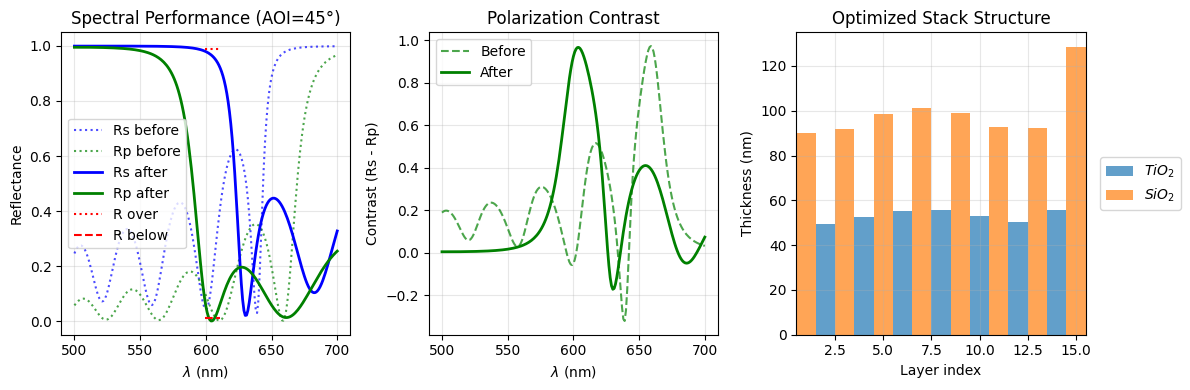

In [6]:

import matplotlib.pyplot as plt

analyzer = SpectralAnalyzer(dichroic_stack)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

wl_range = be.linspace(500, 700, 201)  # Around 600 nm

# Calculate before optimization (reset and recalculate)
optimizer.reset()
Rs_before = dichroic_stack.reflectance_nm_deg(wl_range, 45, 's')
Rp_before = dichroic_stack.reflectance_nm_deg(wl_range, 45, 'p')

# Restore optimized state
for i, var_info in enumerate(optimizer.variables):
    final_thickness = result['thickness_changes'][i]['final_nm'] / 1000  # nm → μm
    dichroic_stack.layers[i].update_thickness(final_thickness)

Rs_after = dichroic_stack.reflectance_nm_deg(wl_range, 45, 's')
Rp_after = dichroic_stack.reflectance_nm_deg(wl_range, 45, 'p')

axes[0].plot(wl_range, Rs_before, 'b:', label='Rs before', alpha=0.7)
axes[0].plot(wl_range, Rp_before, 'g:', label='Rp before', alpha=0.7)
axes[0].plot(wl_range, Rs_after, 'b-', label='Rs after', linewidth=2)
axes[0].plot(wl_range, Rp_after, 'g-', label='Rp after', linewidth=2)
optimizer.plot_targets(axes[0])
axes[0].set_xlabel('$\lambda$ (nm)')
axes[0].set_ylabel('Reflectance')
axes[0].set_title('Spectral Performance (AOI=45°)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Polarization contrast (Rs - Rp)
contrast_before = Rs_before - Rp_before
contrast_after = Rs_after - Rp_after

axes[1].plot(wl_range, contrast_before, 'g--', label='Before', alpha=0.7)
axes[1].plot(wl_range, contrast_after, 'g-', label='After', linewidth=2)
axes[1].set_xlabel('$\lambda$ (nm)')
axes[1].set_ylabel('Contrast (Rs - Rp)')
axes[1].set_title('Polarization Contrast')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Optimized stack structure
dichroic_stack.plot_structure_thickness(axes[2])
axes[2].set_title('Optimized Stack Structure')
fig.tight_layout()
